In [1]:
import pickle
from lightgbm import LGBMRegressor
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os

In [2]:
def run_load_xy(years, dy=0, dq=1, save_dir='xy_data', aq='a'):
    DATA_FOLDER = '/Users/mmw/Documents/GitHub/ml_val/data_all'
    folder = '_'.join(['xy', aq, str(dy), str(dq)])
    if not os.path.exists(os.path.join(DATA_FOLDER, folder)):
        raise Exception('Preprocessed xy data folder not found')
    if not os.path.exists(os.path.join(DATA_FOLDER, save_dir)):
        os.mkdir(os.path.join(DATA_FOLDER, save_dir))

    x_df_set, y_df_set = pd.DataFrame(), pd.DataFrame()

    for year in years:
        with open(os.path.join(DATA_FOLDER, folder, '_'.join(['x', str(year)]) + '.pkl'), 'rb') as handle:
            x_df_ = pickle.load(handle)
        with open(os.path.join(DATA_FOLDER, folder, '_'.join(['y', str(year)]) + '.pkl'), 'rb') as handle:
            y_df_ = pickle.load(handle)
        x_df_set = pd.concat([x_df_set, x_df_], axis=0)
        y_df_set = pd.concat([y_df_set, y_df_], axis=0)

    return x_df_set, y_df_set

In [3]:
def train_test_process(tr_start=1975, tr_duration=30, ts_duration=1, dy=1, dq=0, plot=True):
    
    tr_years = [tr_start+i for i in range(tr_duration)]
    print(tr_years)
    ts_years = [tr_start+tr_duration+i for i in range(ts_duration)]
    print(ts_years)
    
    x_tr_set, y_tr_set = run_load_xy(tr_years, dy=dy, dq=dq)
    x_ts_set, y_ts_set = run_load_xy(ts_years, dy=dy, dq=dq)
    
    x_tr = x_tr_set.iloc[:,5:]
    x_tr.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    x_tr = x_tr.fillna(0).astype('float32')
    
    y_tr = y_tr_set.iloc[:,5:]
    y_tr.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    y_tr = y_tr.fillna(0).astype('float32')
    
    x_ts = x_ts_set.iloc[:,5:]
    x_ts.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    x_ts = x_ts.fillna(0).astype('float32')
    
    y_ts = y_ts_set.iloc[:,5:]
    y_ts.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    y_ts = y_ts.fillna(0).astype('float32')
    
    oosr2 = {}
    oosr2single = {}
    max1 = {}
    max2 = {}
    max3= {}
    max4 = {}
    max5 = {}

    def single_feature_oosr2(item, x_tr=x_tr, y_tr=y_tr, x_ts=x_ts, y_ts=y_ts, 
                             param_test = {'max_depth': [1]}):
        try:
            _ = x_tr[item].values.shape[1]
            x_tr_single = x_tr[item].values[:, 0].reshape(-1, 1)
            y_tr_single = y_tr[item].values
            x_ts_single = x_ts[item].values[:, 0].reshape(-1, 1)
            y_ts_single = y_ts[item].values
        except IndexError:
            x_tr_single = x_tr[item].values.reshape(-1, 1)
            y_tr_single = y_tr[item].values
            x_ts_single = x_ts[item].values.reshape(-1, 1)
            y_ts_single = y_ts[item].values 

        mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
        clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=3)
        clf.fit(x_tr_single, y_tr_single)
        predictions = clf.predict(x_ts_single)

        return sklearn.metrics.r2_score(y_ts_single, predictions)
    
# #     level prediction

#     for item in y_tr.columns:
#         if '_5o5' in item or '_qoq' in item or '_aoa' in item:
#             continue    
#         param_test = {'max_depth': [1, 6], 'num_leaves': [2, 4], 'n_estimators': [20, 100, 500]}
# #         param_test = {'max_depth': [1], 'num_leaves': [2], 'n_estimators': [5]}
#         mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
#         clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=3)
#         clf.fit(x_tr.values, y_tr[item].values)
#         predictions = clf.predict(x_ts.values)
#         y_true = y_ts[item].values 
        
#         if plot is True: 
#             plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
#             plt.title(str(tr_start) + ' ' + item)
#             plt.show()
            
#         max_fea = []
#         max_5 = clf.best_estimator_.feature_importances_.argsort()[-5:][::-1]
#         for index in max_5:
#             max_fea.append(x_tr.columns[index])
#         oosr2[item] = sklearn.metrics.r2_score(y_true, predictions)
#         try:
#             sig_feature_oosr2 = single_feature_oosr2(item, param_test=param_test)
#             enhancement = (oosr2[item] - sig_feature_oosr2)/sig_feature_oosr2
#             print(tr_start, item, oosr2[item], enhancement, max_fea)
#             print(clf.best_params_)
#             oosr2single[item] = sig_feature_oosr2
#         except KeyError:
#             print(item, oosr2[item], max_fea)
#             print(clf.best_params_)
            
            
    # year on year growth prediction

    for item in y_tr.columns:
        if '_aoa' not in item:
            continue    
        param_test = {'max_depth': [1, 6], 'num_leaves': [2, 4], 'n_estimators': [20, 100, 500]}
#         param_test = {'max_depth': [1], 'num_leaves': [2], 'n_estimators': [20, 100, 500]}
        mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
        clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=5)
        clf.fit(x_tr.values, y_tr[item].values)
        predictions = clf.predict(x_ts.values)
        y_true = y_ts[item].values 
        plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
        plt.show()
        max_fea = []
        max_5 = clf.best_estimator_.feature_importances_.argsort()[-5:][::-1]
        for index in max_5:
            max_fea.append(x_tr.columns[index])
        max1[item], max2[item], max3[item], max4[item], max5[item] = max_fea[0], max_fea[1], max_fea[2], max_fea[3], max_fea[4] 
        oosr2[item] = sklearn.metrics.r2_score(y_true, predictions)
        try:
            sig_feature_oosr2 = single_feature_oosr2(item, param_test=param_test)
            enhancement = (oosr2[item] - sig_feature_oosr2)/sig_feature_oosr2
            oosr2single[item] = sig_feature_oosr2
            print(tr_start, item, oosr2[item], enhancement, max_fea)
            print(clf.best_params_)
        except KeyError:
            print(item, oosr2[item], max_fea)
            print(clf.best_params_)
    
    return oosr2, oosr2single, max1, max2, max3, max4, max5

[1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]
[2005]


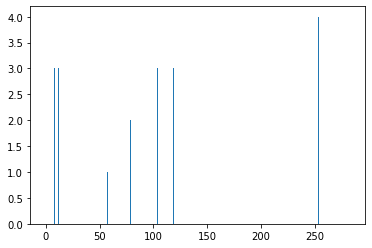

1975 revt_aoa 0.01672651480995324 -14.456652016713456 ['roe_med_aoa', 'chatoia', 'gma_aoa', 'chpmia', 'revt_5o5']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


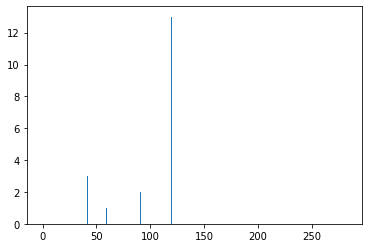

1975 ebit_aoa -0.02477957308320433 224.875146044151 ['ebit_5o5', 'pctacc', 'pe', 'pe_aoa', 'tb']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


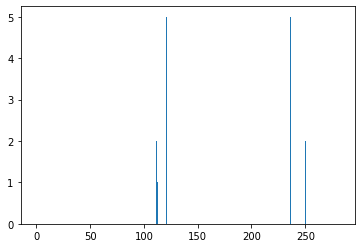

1975 ebitda_aoa -0.007676448185952367 2.745094036486401 ['ebitda_5o5', 'ebit_sum_aoa', 'mom36m', 'chtx', 'dpr_med_aoa']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


In [ ]:
oosr2df, oosr2singledf, max1df, max2df, max3df, max4df, max5df = None, None, None,None,None,None,None

start_training_year = 1975
end_training_year = 2018

for tr_start in range(start_training_year, end_training_year, 1):
    
    oosr2, oosr2single, max1, max2, max3, max4, max5 = train_test_process(tr_start=tr_start, tr_duration=30, ts_duration=1, dy=1, dq=0)
    
    if oosr2df is None:
        oosr2df = pd.DataFrame.from_dict(oosr2, orient='index', columns=[tr_start])
        oosr2singledf = pd.DataFrame.from_dict(oosr2single, orient='index', columns=[tr_start])
        max1df = pd.DataFrame.from_dict(max1, orient='index', columns=[tr_start])
        max2df = pd.DataFrame.from_dict(max2, orient='index', columns=[tr_start])
        max3df = pd.DataFrame.from_dict(max3, orient='index', columns=[tr_start])
        max4df = pd.DataFrame.from_dict(max4, orient='index', columns=[tr_start])
        max5df = pd.DataFrame.from_dict(max5, orient='index', columns=[tr_start])
        
    else:
        oosr2df = pd.concat([oosr2df, pd.DataFrame.from_dict(oosr2, orient='index', columns=[tr_start])], axis=1)
        oosr2singledf = pd.concat([oosr2singledf, pd.DataFrame.from_dict(oosr2single, orient='index', columns=[tr_start])], axis=1)
        max1df = pd.concat([max1df, pd.DataFrame.from_dict(max1, orient='index', columns=[tr_start])], axis=1)
        max2df = pd.concat([max2df, pd.DataFrame.from_dict(max2, orient='index', columns=[tr_start])], axis=1)
        max3df = pd.concat([max3df, pd.DataFrame.from_dict(max3, orient='index', columns=[tr_start])], axis=1)
        max4df = pd.concat([max4df, pd.DataFrame.from_dict(max4, orient='index', columns=[tr_start])], axis=1)
        max5df = pd.concat([max5df, pd.DataFrame.from_dict(max5, orient='index', columns=[tr_start])], axis=1)
    
    oosr2df.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["oosr2", 'a', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))
    oosr2singledf.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["oosr2single", 'q', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))
    max1df.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["max1", 'a', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))
    max2df.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["max2", 'a', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))
    max3df.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["max3", 'a', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))
    max4df.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["max4", 'a', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))
    max5df.to_csv(os.path.join('/Users/mmw/Documents/GitHub/ml_val/train/rl_result', '_'.join(["max5", 'a', str(0), str(1), str(start_training_year), str(end_training_year)]) + '.csv'))